In [92]:
# Import packages

import time
import re
import itertools

import pandas as pd
import numpy as np
#import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import boxcox

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, root_mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pmdarima as pm

from prophet import Prophet
from prophet.make_holidays import make_holidays_df

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Conv1D, Dense, Dropout, Flatten, GRU, Input, LSTM, MaxPooling1D 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [2]:
# Set display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_info_columns', 100)
pd.set_option('display.max_info_rows', 100)

## Data Preparation

In [3]:
%%time

# Read in 311 data
df_311_calls = pd.read_csv('Data/311_Service_Requests_20240430.csv',
                     index_col = 'Unique Key',
                     usecols = ['Agency','Borough','Complaint Type',
                              'Created Date','Incident Zip',#'Latitude','Longitude',
                              'Unique Key'],
                     dtype = {'Agency':'category','Borough':'category','Complaint Type':str,
                              'Created Date':str,'Incident Zip':str,#'Latitude':float,'Longitude':float,
                              'Unique Key':'int64'})

# Rename columns
df_311_calls.rename({'Complaint Type': 'Type', 'Created Date': 'Date', 'Incident Zip': 'Zip'}, axis=1, inplace=True)

CPU times: total: 3min 20s
Wall time: 3min 21s


In [4]:
# Read in NYC zip codes

df_zips = pd.read_csv('Data/uszips/uszips.csv',
                     index_col = 'zip',
                     dtype = {'borough': str, 'zip': str} )

In [5]:
# Load shapefile of zip codes
#filtered_shapefile_path = 'Data/USA_ZIP_Code_Boundaries/filtered_zip_code_shapefile.shp'
#filtered_zip_codes_gdf = gpd.read_file(filtered_shapefile_path)

##### Drop unusable rows

In [6]:
print(f'Initial items: {len(df_311_calls):,.0f}')

Initial items: 36,217,243


In [7]:
# Drop rows with no useable location data
no_loc = df_311_calls['Zip'].isna() #& df_311['Latitude'].isna()
df_311_calls = df_311_calls[~no_loc]
print(f'Rows with locations: {len(df_311_calls):,.0f}')

Rows with locations: 34,682,301


In [8]:
%%time
# Convert date columns to datetime, dropping time component and dropping dates after March 31, 2024
date_format = '%m/%d/%Y %I:%M:%S %p'
df_311_calls['Date'] = pd.to_datetime(df_311_calls['Date'], format=date_format).values.astype('datetime64[D]')
df_311_calls = df_311_calls[df_311_calls['Date'] < pd.Timestamp('2024-04-01')]
print(f'Rows in the date range: {len(df_311_calls):,.0f}')

Rows in the date range: 34,435,921
CPU times: total: 2min 28s
Wall time: 2min 28s


In [9]:
# Convert NaN values in 'Incident Zip' to 'empty', to simplify further processing
df_311_calls['Zip'] = df_311_calls['Zip'].fillna('empty')
df_311_calls.isna().sum()

# Clean up ZIP codes by removing '-####' if present
df_311_calls['Zip'] = df_311_calls['Zip'].str.replace(r'-\d{4}$', '', regex=True)

# Drop all rows with zip codes not in NYC
df_311_calls = df_311_calls[df_311_calls['Zip'].isin(df_zips.index)]
print(f'Rows in NYC: {len(df_311_calls):,.0f}')

Rows in NYC: 34,388,549


In [10]:
# Fill in latitude and longitude when a zip code is available

# Latitude and longitude from US Zip Code file
#zip_to_lat = df_zip['lat'].to_dict()
#zip_to_lng = df_zip['lng'].to_dict()

# Fill in missing latitude and longitude using the mapping, but only if values don't already exist
#df_311.loc[df_311['Latitude'].isna(), 'Latitude'] = df_311['Zip'].map(zip_to_lat)
#df_311.loc[df_311['Longitude'].isna(), 'Longitude'] = df_311['Zip'].map(zip_to_lng)

##### Consolidate Agencies and Types

In [11]:
# Consolidate agencies, replacing minor agencies with 'Other'
agency_dict = {
    'NYPD': 'Police',
    'HPD': 'Housing',
    'DSNY': 'Sanitation',
    'DOT': 'Transportation',
    'DEP': 'Environment',
    'DOB': 'Buildings',
    'DPR': 'Parks',
    'DOMHM': 'Health',
    'DOF': 'Finance',
    'TLC': 'Taxi',
    'DHS': 'Homeless',
    'DCA': 'Consumer',
    'DEPARTMENT OF CONSUMER AND WORKER PROTECTION': 'Consumer',
    'EDC': 'Development',
    'HRA': 'Human Resources',
    'DFTA': 'Aging',
    'OSE': 'ST Rentals',
}

df_311_calls['Agency'] = df_311_calls['Agency'].map(agency_dict).fillna('Other')

In [12]:
# Convert all line items to lowercase
df_311_calls['Type'] = df_311_calls['Type'].str.lower()

In [13]:
# Convert complaint types to fewer categories
complaint_dict = {
    'noise - residential': 'Noise',
    'illegal parking': 'Vehicle',
    'heat/hot water': 'Resident Utility',
    'blocked driveway': 'Vehicle',
    'street condition': 'Street Condition',
    'noise - street/sidewalk': 'Noise',
    'street light condition': 'Traffic Device',
    'request large bulky item collection': 'Item Pickup',
    'plumbing': 'Resident Utility',
    'heating': 'Resident Utility',
    'water system': 'Resident Utility',
    'unsanitary condition': 'Sanitation',
    'noise': 'Noise',
    'general construction/plumbing': 'Resident Utility',
    'traffic signal condition': 'Traffic Device',
    'noise - commercial': 'Noise',
    'paint/plaster': 'Buildings',
    'noise - vehicle': 'Noise',
    'general construction': 'Construction',
    'sewer': 'Sewer',
    'damaged tree': 'Tree',
    'rodent': 'Sanitation',
    'dirty conditions': 'Sanitation',
    'electric': 'Resident Utility',
    'derelict vehicles': 'Vehicle',
    'sanitation condition': 'Sanitation',
    'door/window': 'Buildings',
    'paint - plaster': 'Buildings',
    'sidewalk condition': 'Street Condition',
    'water leak': 'Resident Utility',
    'building/use': 'Buildings',
    'missed collection (all materials)': 'Sanitation',
    'literature request': 'Other',
    'consumer complaint': 'Consumer',
    'general': 'Other',
    'homeless person assistance': 'Social Services',
    'nonconst': 'Other',
    'abandoned vehicle': 'Vehicle',
    'new tree request': 'Tree',
    'flooring/stairs': 'Buildings',
    'graffiti': 'Quality of Life',
    'overgrown tree/branches': 'Tree',
    'non-emergency police matter': 'Police',
    'derelict vehicle': 'Vehicle',
    'maintenance or facility': 'Other',
    'taxi complaint': 'Taxi',
    'appliance': 'Buildings',
    'elevator': 'Buildings',
    'broken muni meter': 'Parking',
    'missed collection': 'Sanitation',
    'noise - helicopter': 'Noise',
    'root/sewer/sidewalk condition': 'Street Condition',
    'food establishment': 'Vendors',
    'for hire vehicle complaint': 'Taxi',
    'dirty condition': 'Sanitation',
    'air quality': 'Environmental',
    'benefit card replacement': 'Social Services',
    'encampment': 'Social Services',
    'dof property - reduction issue': 'Finance',
    'lead': 'Public Health',
    'safety': 'Other',
    'street sign - damaged': 'Traffic Device',
    'illegal fireworks': 'Quality of Life',
    'snow': 'Snow',
    'electronics waste appointment': 'Item Pickup',
    'scrie': 'Housing',
    'dead/dying tree': 'Tree',
    'illegal dumping': 'Sanitation',
    'broken parking meter': 'Parking',
    'other enforcement': 'Police',
    'dof parking - payment issue': 'Finance',
    'indoor air quality': 'Buildings',
    'noise - park': 'Noise',
    'curb condition': 'Street Condition',
    'street sign - missing': 'Traffic Device',
    'noncompliance with phased reopening': 'Public Health',
    'dof property - owner issue': 'Finance',
    'traffic': 'Traffic Device',
    'dof property - request copy': 'Finance',
    'highway condition': 'Street Condition',
    'dead tree': 'Tree',
    'emergency response team (ert)': 'Buildings',
    'special projects inspection team (spit)': 'Construction',
    'water conservation': 'Parks and Rec',
    'dof property - payment issue': 'Finance',
    'hpd literature request': 'Housing',
    'animal abuse': 'Animal',
    'housing - low income senior': 'Housing',
    'drug activity': 'Police',
    'vending': 'Quality of Life',
    'electrical': 'Resident Utility',
    'illegal tree damage': 'Tree',
    'dhs advantage - tenant': 'Housing',
    'food poisoning': 'Public Health',
    'street sign - dangling': 'Traffic Device',
    'violation of park rules': 'Parks and Rec',
    'homeless encampment': 'Social Services',
    'smoking': 'Public Health',
    'animal-abuse': 'Animal',
    'animal in a park': 'Animal',
    'hazardous materials': 'Environmental',
    'obstruction': 'Vehicle',
    'construction': 'Construction',
    'lost property': 'Other',
    'litter basket / request': 'Sanitation',
    'boilers': 'Resident Utility',
    'construction safety enforcement': 'Construction',
    'dhs advantage -landlord/broker': 'Housing',
    'unsanitary animal pvt property': 'Animal',
    'drinking': 'Social Services',
    'residential disposal complaint': 'Sanitation',
    'standing water': 'Environmental',
    'electronics waste': 'Item Pickup',
    'panhandling': 'Social Services',
    'dca / doh new license application request': 'Vendors',
    'asbestos': 'Buildings',
    'dead animal': 'Animal',
    'dof property - update account': 'Finance',
    'outdoor dining': 'Vendors',
    'best/site safety': 'Construction',
    'street sweeping complaint': 'Street Condition',
    'water quality': 'Resident Utility',
    'vendor enforcement': 'Vendors',
    'real time enforcement': 'Buildings',
    'housing options': 'Housing',
    'bus stop shelter complaint': 'Social Services',
    'industrial waste': 'Environmental',
    'bike/roller/skate chronic': 'Quality of Life',
    'mobile food vendor': 'Vendors',
    'overflowing litter baskets': 'Sanitation',
    'derelict bicycle': 'Vehicle',
    'noise survey': 'Noise',
    'non-residential heat': 'Buildings',
    'miscellaneous categories': 'Other',
    'homeless street condition': 'Social Services',
    'noise - house of worship': 'Noise',
    'taxi report': 'Taxi',
    'traffic/illegal parking': 'Vehicle',
    'unleashed dog': 'Animal',
    'indoor sewage': 'Resident Utility',
    'outside building': 'Other',
    'snow or ice': 'Snow',
    'dof parking - request status': 'Finance',
    'unsanitary pigeon condition': 'Animal',
    'sweeping/missed': 'Street Condition',
    'dof parking - request copy': 'Finance',
    'recycling enforcement': 'Sanitation',
    'dpr internal': 'Parks and Rec',
    'urinating in public': 'Social Services',
    'litter basket request': 'Sanitation',
    'day care': 'Social Services',
    'illegal posting': 'Quality of Life',
    'borough office': 'Other',
    'sanitation worker or vehicle complaint': 'Sanitation',
    'vaccine mandate non-compliance': 'Public Health',
    'covid-19 non-essential construction': 'Construction',
    'building marshals office': 'Buildings',
    'commercial disposal complaint': 'Sanitation',
    'dof parking - tax exemption': 'Finance',
    'bridge condition': 'Street Condition',
    'sustainability enforcement': 'Sanitation',
    'taxi compliment': 'Taxi',
    'elder abuse': 'Social Services',
    'sweeping/missed-inadequate': 'Street Condition',
    'disorderly youth': 'Social Services',
    'abandoned bike': 'Vehicle',
    'mold': 'Buildings',
    'dumpster complaint': 'Sanitation',
    'illegal animal kept as pet': 'Animal',
    'mosquitoes': 'Environmental',
    'for hire vehicle report': 'Taxi',
    'drie': 'Housing',
    'found property': 'Other',
    'home delivered meal - missed delivery': 'Social Services',
    'litter basket complaint': 'Sanitation',
    'construction lead dust': 'Environmental',
    'mass gathering complaint': 'Quality of Life',
    'cranes and derricks': 'Construction',
    'dof property - rpie issue': 'Finance',
    'posting advertisement': 'Quality of Life',
    'home repair': 'Buildings',
    'harboring bees/wasps': 'Animal',
    'scaffold safety': 'Construction',
    'adopt-a-basket': 'Sanitation',
    'senior center complaint': 'Social Services',
    'plant': 'Other',
    'window guard': 'Buildings',
    'sewer maintenance': 'Sewer',
    'snow removal': 'Snow',
    'sweeping/inadequate': 'Street Condition',
    "alzheimer's care": 'Social Services',
    'beach/pool/sauna complaint': 'Parks and Rec',
    'city vehicle placard complaint': 'Other',
    'drinking water': 'Resident Utility',
    'collection truck noise': 'Sanitation',
    'question': 'Other',
    'facades': 'Buildings',
    'private or charter school reopening': 'Public Health',
    'dof property - property value': 'Finance',
    'dof parking - dmv clearance': 'Finance',
    'request xmas tree collection': 'Item Pickup',
    'poison ivy': 'Environmental',
    'oem disabled vehicle': 'Vehicle',
    'uprooted stump': 'Tree',
    'wood pile remaining': 'Construction',
    'face covering violation': 'Public Health',
    'tattooing': 'Other',
    'heap assistance': 'Resident Utility',
    'highway sign - damaged': 'Traffic Device',
    'quality of life': 'Quality of Life',
    'utility program': 'Resident Utility',
    'executive inspections': 'Buildings',
    'forms': 'Other',
    'dhs advantage - third party': 'Public Health',
    'unsanitary animal facility': 'Vendors',
    'green taxi complaint': 'Taxi',
    'dof property - city rebate': 'Finance',
    'forensic engineering': 'Buildings',
    'weatherization': 'Buildings',
    'pet shop': 'Vendors',
    'animal facility - no permit': 'Vendors',
    'special natural area district (snad)': 'Parks and Rec',
    'municipal parking facility': 'Parking',
    'home delivered meal complaint': 'Social Services',
    'illegal animal sold': 'Animal',
    'seasonal collection': 'Item Pickup',
    'dep street condition': 'Street Condition',
    'stalled sites': 'Other',
    'advocate-personal exemptions': 'Finance',
    'highway sign - missing': 'Traffic Device',
    'ahv inspection unit': 'Vendors',
    'e-scooter': 'Quality of Life',
    'public toilet': 'Parks and Rec',
    'eviction': 'Housing',
    'fatf': 'Finance',
    'dof parking - address update': 'Parking',
    'advocate-prop refunds/credits': 'Finance',
    'water maintenance': 'Resident Utility',
    'highway sign - dangling': 'Traffic Device',
    'parking card': 'Parking',
    'taxpayer advocate inquiry': 'Finance',
    'summer camp': 'Parks and Rec',
    'special operations': 'Quality of Life',
    'incorrect data': 'Other',
    'bereavement support group': 'Social Services',
    'advocate - other': 'Social Services',
    'lifeguard': 'Parks and Rec',
    'squeegee': 'Quality of Life',
    'x-ray machine/equipment': 'Other',
    'home care provider complaint': 'Social Services',
    'case management agency complaint': 'Social Services',
    'atf': 'Police',
    'private school vaccine mandate non-compliance': 'Public Health',
    'overflowing recycling baskets': 'Sanitation',
    'comments': 'Other',
    'cooling tower': 'Buildings',
    'recycling basket complaint': 'Sanitation',
    'calorie labeling': 'Vendors',
    'legal services provider complaint': 'Social Services',
    'health': 'Public Health',
    'radioactive material': 'Environmental',
    'dhs income savings requirement': 'Housing',
    'institution disposal complaint': 'Sanitation',
    'water drainage': 'Environmental',
    'green taxi report': 'Taxi',
    'peeling paint': 'Buildings',
    'tunnel condition': 'Street Condition',
    'building drinking water tank': 'Buildings',
}    

In [14]:
df_311_calls['Type'] = df_311_calls['Type'].map(complaint_dict).fillna('Other')

#### Visualize Distributions

In [15]:
# Clean Borough values for charting
df_311_calls['Borough'] = df_311_calls['Borough'].str.title()

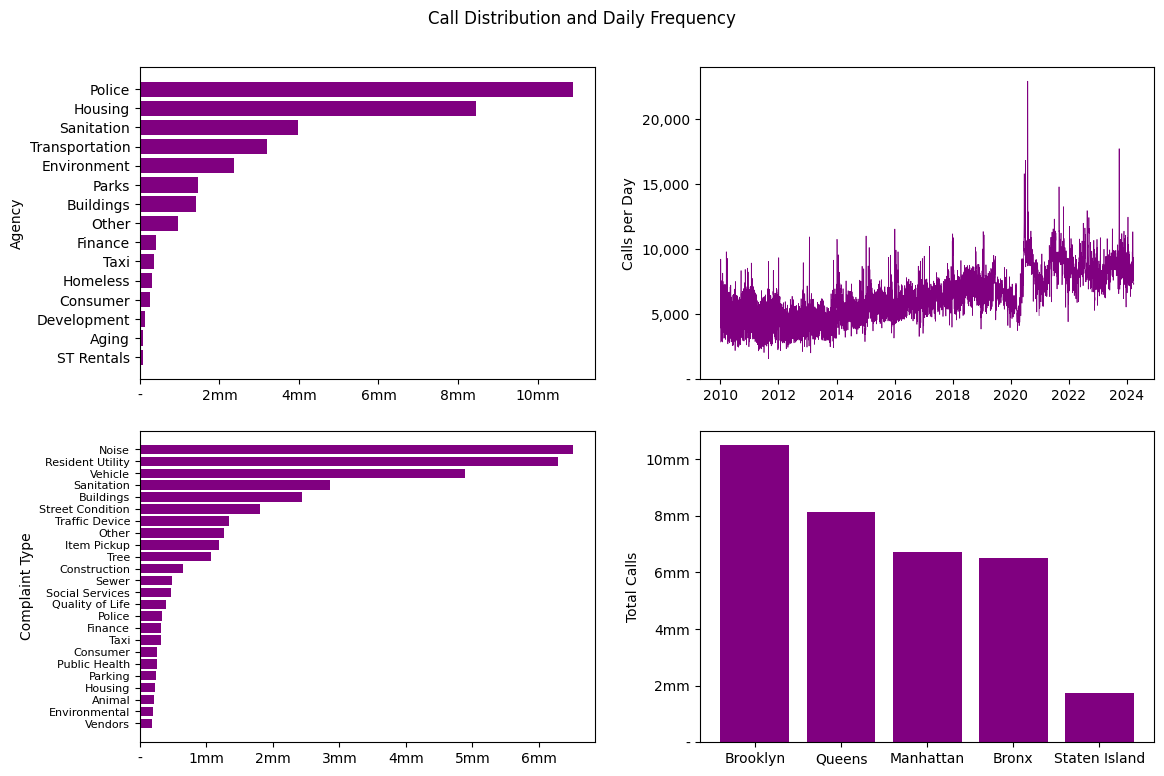

In [16]:
# Visualize call data
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (12,8))
fig.suptitle('Call Distribution and Daily Frequency')
ax1.barh(y = df_311_calls['Agency'].value_counts().sort_values(ascending=True).index[1:], width = df_311_calls['Agency'].value_counts().sort_values(ascending=True)[1:], color='purple')
ax1.set_xticks([0,2000000,4000000,6000000,8000000,10000000])
ax1.set_xticklabels(['-','2mm','4mm','6mm','8mm','10mm'])
ax1.set_ylabel('Agency')
ax2.plot(df_311_calls['Date'].value_counts().sort_index(), linewidth=0.5, color='purple')
ax2.set_yticks([0,5000,10000,15000,20000])
ax2.set_yticklabels(['-','5,000','10,000','15,000','20,000'])
ax2.set_ylabel('Calls per Day')
ax3.barh(y= df_311_calls['Type'].value_counts().sort_values(ascending=True).index[2:], width = df_311_calls['Type'].value_counts().sort_values(ascending=True)[2:], color='purple')
ax3.tick_params(axis='y', labelsize=8)
ax3.set_xticks([0,1000000,2000000,3000000,4000000,5000000,6000000])
ax3.set_xticklabels(['-','1mm','2mm','3mm','4mm','5mm','6mm'])
ax3.set_ylabel('Complaint Type')
ax4.bar(x=df_311_calls['Borough'].value_counts().sort_values(ascending=False)[:-1].index, height=df_311_calls['Borough'].value_counts().sort_values(ascending=False)[:-1], color='purple')
ax4.set_yticks([0,2000000,4000000,6000000,8000000,10000000])
ax4.set_yticklabels(['-','2mm','4mm','6mm','8mm','10mm'])
ax4.set_ylabel('Total Calls')
plt.tight_layout(pad=2.0)
plt.show()

### Weather

In [17]:
# Read in NYC weather data, and format
df_weather = pd.read_csv('Data/NYC_weather_data.csv')
df_weather.drop('Unnamed: 0', axis=1, inplace=True)
df_weather['date'] = pd.to_datetime(df_weather['date']).values.astype('datetime64[D]')
df_weather.set_index('date',inplace=True)
df_weather.drop_duplicates(inplace=True)
df_weather = df_weather[df_weather.index < pd.Timestamp('2024-04-01')]
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5204 entries, 2010-01-01 to 2024-03-31
Data columns (total 7 columns):
 #   Column               Dtype  
---  ------               -----  
 0   temperature_2m_max   float64
 1   temperature_2m_min   float64
 2   temperature_2m_mean  float64
 3   daylight_duration    float64
 4   rain_sum             float64
 5   snowfall_sum         float64
 6   wind_speed_10m_max   float64
dtypes: float64(7)
memory usage: 325.2 KB


#### Visualize

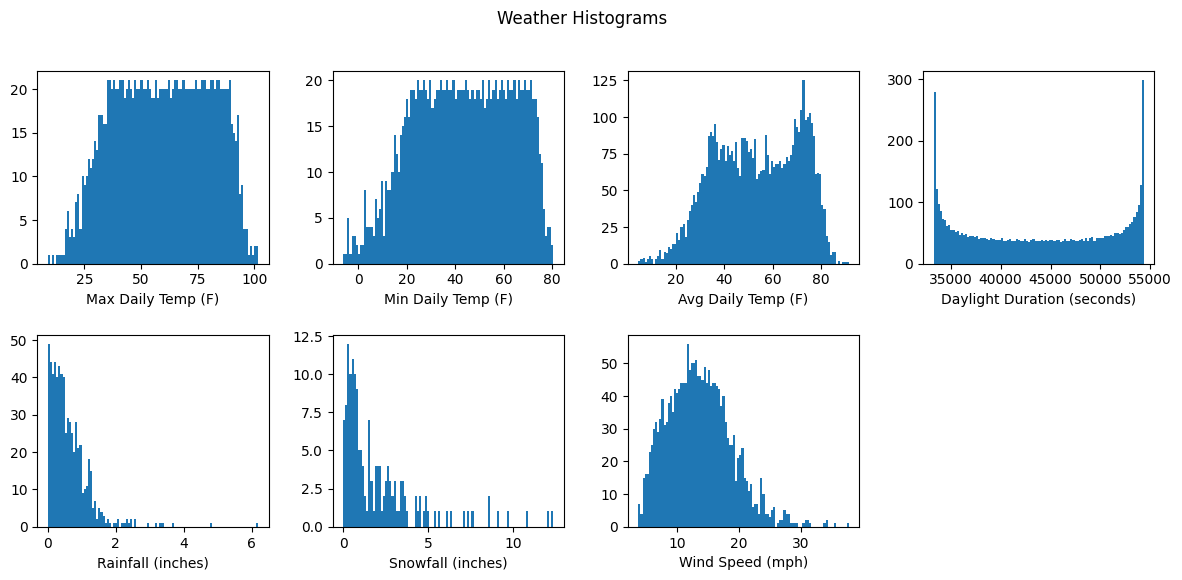

In [18]:
# Visualize weather data
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(12,6))
fig.suptitle('Weather Histograms')
ax1.hist(df_weather['temperature_2m_max'].value_counts().index, bins=100)
ax1.set_xlabel('Max Daily Temp (F)')
ax2.hist(df_weather['temperature_2m_min'].value_counts().index, bins=100)
ax2.set_xlabel('Min Daily Temp (F)')
ax3.hist(df_weather['temperature_2m_mean'].value_counts().index, bins=100)
ax3.set_xlabel('Avg Daily Temp (F)')
ax4.hist(df_weather['daylight_duration'].value_counts().index, bins=100)
ax4.set_xlabel('Daylight Duration (seconds)')
ax5.hist(df_weather['rain_sum'].value_counts().index, bins=100)
ax5.set_xlabel('Rainfall (inches)')
ax6.hist(df_weather['snowfall_sum'].value_counts().index, bins=100)
ax6.set_xlabel('Snowfall (inches)')
ax7.hist(df_weather['wind_speed_10m_max'].value_counts().index, bins=100)
ax7.set_xlabel('Wind Speed (mph)')
ax8.axis('off')
plt.tight_layout(pad=2.0)
plt.show;

#### Scaling
- Rainfall, snowfall and wind speed: Box-Cox transformation, addresses right-skewed distributions
- Temperatures - Temperatures are normally distributed when holding seasonality constant.  Seasonal decompose first, then standard scale, then seasonal recompose
- Daylight Duration - Minmax scaling

In [19]:
# Scaling functions for weather data

# log transform with a small constant
def log_transform(series, constant=1e-6):
    return np.log(series + constant)

# Helper function to apply Box-Cox transformation
def boxcox_transform(series):
    series_nonzero = series + 1e-6  # Add small constant to avoid zero values
    transformed_data, _ = boxcox(series_nonzero)
    return pd.Series(transformed_data, index=series.index)

# Seasonal decompose and recompose function
def decompose_and_scale(series, period=365):
    series = series.dropna()  # Drop NaNs if any
    decomposition = seasonal_decompose(series, model='additive', period=period)
    seasonal = decomposition.seasonal
    adjusted_series = series - seasonal  # Adjust the original series by removing the seasonal component

    scaler = StandardScaler()
    scaled_series = scaler.fit_transform(adjusted_series.values.reshape(-1, 1))

    scaled_series_full = pd.Series(scaled_series.flatten(), index=adjusted_series.index)
    scaled_series_full = scaled_series_full.reindex(series.index).bfill().ffill()

    return scaled_series_full


In [20]:
# Applying transformations

# Temperature columns: seasonal decompose, scale, recompose
df_weather['temperature_2m_max_scaled'] = decompose_and_scale(df_weather['temperature_2m_max'])
df_weather['temperature_2m_min_scaled'] = decompose_and_scale(df_weather['temperature_2m_min'])
df_weather['temperature_2m_mean_scaled'] = decompose_and_scale(df_weather['temperature_2m_mean'])

# Daylight duration: MinMax scale
df_weather['daylight_duration_scaled'] = MinMaxScaler().fit_transform(df_weather['daylight_duration'].values.reshape(-1, 1))

# Rainfall and Snowfall: Log transform with small constant
df_weather['rain_sum_log'] = boxcox_transform(df_weather['rain_sum'])
df_weather['snowfall_sum_log'] = boxcox_transform(df_weather['snowfall_sum'])

# Wind speed: Log transform
df_weather['wind_speed_10m_max_log'] = boxcox_transform(df_weather['wind_speed_10m_max'])

# Dropping original columns if no longer needed
df_weather.drop(columns=['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean',
                         'daylight_duration', 'rain_sum', 'snowfall_sum', 'wind_speed_10m_max'], inplace=True)

# Renaming the transformed columns
df_weather.rename(columns={
    'temperature_2m_max_scaled': 'temperature_2m_max',
    'temperature_2m_min_scaled': 'temperature_2m_min',
    'temperature_2m_mean_scaled': 'temperature_2m_mean',
    'daylight_duration_scaled': 'daylight_duration',
    'rain_sum_log': 'rain_sum',
    'snowfall_sum_log': 'snowfall_sum',
    'wind_speed_10m_max_log': 'wind_speed_10m_max'
}, inplace=True)

# Displaying the transformed dataframe
print(df_weather.head())

            temperature_2m_max  temperature_2m_min  temperature_2m_mean  \
date                                                                      
2010-01-01            0.175818           -0.667740            -0.294884   
2010-01-02           -1.375657           -2.075379            -1.380453   
2010-01-03           -2.189736           -2.108758            -2.462976   
2010-01-04           -1.001858           -0.838221            -1.217928   
2010-01-05           -1.339170           -1.280739            -1.694560   

            daylight_duration   rain_sum  snowfall_sum  wind_speed_10m_max  
date                                                                        
2010-01-01           0.011686  -5.086032 -1.473707e+00            1.872807  
2010-01-02           0.013809  -6.568085 -2.786367e+00            2.729425  
2010-01-03           0.016103 -21.517231 -9.017416e+00            2.970008  
2010-01-04           0.018563 -21.517231 -2.600800e+06            2.462322  
2010-01-05  

## Modeling
- Perform Baseline model, 1 day shift (equal to ARIMA(0,1,0))
- Step up to ARIMA model to see if performance can be improved
- Search for seasonality (weekly and annually) and apply SARIMA if found
- SARIMA can only handle one dimension of seasonality, consider TBATs for more than one period
  

In [21]:
# Identify future target columns
target_cols = ['Agency', 'Type', 'Zip', 'Borough']

# Create Master dataset to use for modeling
df_311_dates = df_311_calls.drop(columns=target_cols, axis=1)
time_series = df_311_dates.groupby('Date').size().reset_index(name='Count')
time_series.set_index('Date', inplace=True)

# Dummy for COVID period  ###################### should change this to covid lockdowns
lockdown1 = pd.date_range(start='2020-03-21', end='2020-06-06', inclusive='both')
lockdown2 = pd.date_range(start='2021-07-09', end='2021-10-27', inclusive='both')
lockdown3 = pd.date_range(start='2021-02-13', end='2021-02-17', inclusive='both')
lockdown4 = pd.date_range(start='2021-05-28', end='2021-06-10', inclusive='both')
lockdowns = lockdown1.union(lockdown2).union(lockdown3).union(lockdown4)

time_series['covid'] = time_series.index.isin(lockdowns) * 1
time_series['winter'] = (time_series.index.month <= 2) * 1
time_series['weekend'] = (time_series.index.dayofweek >= 5) * 1
time_series['311_app'] = (time_series.index >= pd.Timestamp('2013-03-19')) * 1

time_series = pd.concat([time_series, df_weather], axis=1)

In [22]:
# Interpolate NYC population using US Census estimates
population_data = {
    'date': pd.to_datetime(['2010-01-01', '2010-07-01', '2011-07-01', '2012-07-01', '2013-07-01', '2014-07-01',
                            '2015-07-01', '2016-07-01', '2017-07-01', '2018-07-01', '2019-07-01',
                            '2020-04-01', '2020-07-01', '2021-07-01', '2022-07-01', '2023-07-01', '2024-03-31']),
    'population': [8175133, 8190209, 8251281, 8312676, 8374527, 8436839, 8499614, 8562857, 8626570, 8690757, 8755421, 8804199, 8740292, 8462216, 8335798, 8258035, 8200257]
}

# Create DataFrame
population_df = pd.DataFrame(population_data)

# Set the date as index
population_df.set_index('date', inplace=True)

# Generate a date range from 2010-01-01 to 2024-03-31
date_range = pd.date_range(start='2010-01-01', end='2024-03-31', freq='D')

# Reindex the population data to the full date range, using interpolation to fill in the gaps
population_daily_df = population_df.reindex(date_range)
population_daily_df['population'] = population_daily_df['population'].interpolate(method='linear')

# Scale population numbers
population_daily_df['population'] = MinMaxScaler().fit_transform(population_daily_df['population'].values.reshape(-1, 1))

time_series = pd.concat([time_series, population_daily_df], axis=1)
time_series = time_series.asfreq('D')

In [23]:
# Create training and testing data sets with a train-test split
split_point = int(len(time_series) * 0.8)
train_df = time_series.iloc[:split_point]
test_df = time_series[split_point:]

### Baseline Model

In [24]:
# Implement ARIMA(0, 1, 0) model (Baseline comparison)
baseline_model = ARIMA(train_df['Count'], order=(0, 1, 0))
baseline_results = baseline_model.fit()

# Forecast using the ARIMA(0, 1, 0) model
baseline_pred = baseline_results.get_forecast(steps=len(test_df))
baseline_y_pred = baseline_pred.predicted_mean

# Calculate evaluation metrics for baseline ARIMA(0, 1, 0) model
baseline_mae = mean_absolute_error(test_df['Count'], baseline_y_pred)
baseline_mape = mean_absolute_percentage_error(test_df['Count'], baseline_y_pred)
baseline_mse = mean_squared_error(test_df['Count'], baseline_y_pred)
baseline_rmse = root_mean_squared_error(test_df['Count'], baseline_y_pred)

# Print baseline model evaluation metrics
print('Performance: Baseline Model')
print('-------------------------')
print(f'MAE: {baseline_mae}')
print(f'MAPE: {baseline_mape:.4f}')
print(f'MSE: {baseline_mse}')
print(f'RMSE: {baseline_rmse}')

Performance: Baseline Model
-------------------------
MAE: 959.418828049952
MAPE: 0.1160
MSE: 1598963.576368876
RMSE: 1264.5013152895003


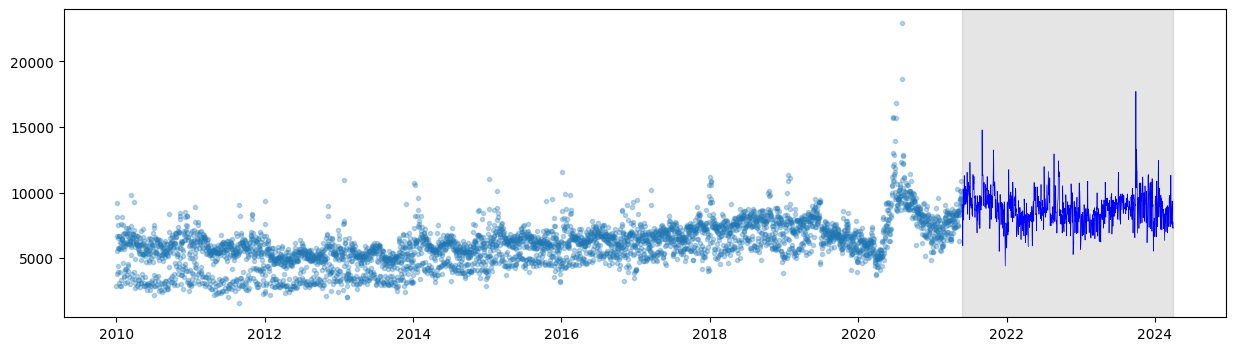

In [25]:
fig, ax = plt.subplots(figsize = (15,4))
ax.scatter(x=train_df['Count'].index, y=train_df['Count'], marker='.', alpha=.3)
# need to map predictions here
ax.plot(test_df['Count'], 'b-', label='Actual', linewidth=0.5)
ax.axvspan(pd.Timestamp('2021-05-26'),pd.Timestamp('2024-03-31'), color='#808080', alpha=0.2)
plt.show()

### First Simple Model: ARIMA

First, test for stationarity:

In [26]:
result = adfuller(time_series['Count'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -2.520885912394666
p-value: 0.11047490316084041


<b><span style="color:red">Not stationary</span></b>  
Because the p-value of the ADF statistics is not less than 0.05, the data is not stationary and must be transformed.  The first transformation will use the one-day difference.

In [27]:
# Transform the data by taking the one-day difference
time_series['Count_diff'] = time_series['Count'].diff().dropna()
result_diff = adfuller(time_series['Count_diff'].dropna())
print(f'ADF Statistic (1st diff): {result_diff[0]}')
print(f'p-value (1st diff): {result_diff[1]}')

ADF Statistic (1st diff): -21.567541398065114
p-value (1st diff): 0.0


<b><span style="color:#15B01A">Stationary</span></b>  
The data is now stationary so the future 'd' term will be 1.  First, plot ACF and PACF to look for good p and q terms, and check for seasonality. 

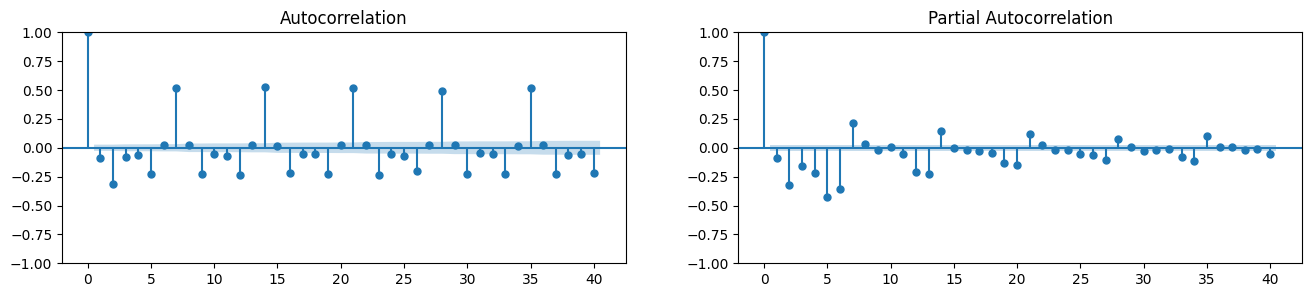

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(16, 3))

plot_acf(time_series['Count_diff'].dropna(), lags=40, ax=axes[0])
plot_pacf(time_series['Count_diff'].dropna(), lags=40, ax=axes[1]);

Drops off after 1 term in each chart, probably means p=1 and q=1.  Since d already equals 1, this means the ideal order is probably (1, 1, 1).  
Also looks like 7-day seasonality, which we'll explore later.  

In [29]:
# Specify all iterations of pdq
p = d = q = range(0, 2)
arima_pdq = list(itertools.product(p, d, q))

# Function to fit ARIMA and calculate AIC
def fit_arima(train, param):
    try:
        model = ARIMA(train, order=param)
        results = model.fit()
        return results.aic, results
    except Exception as e:
        return np.inf, None

# Containers for ARIMA grid search
best_aic = np.inf
best_pdq = None
best_model = None

for param in arima_pdq:
    aic, model = fit_arima(train_df['Count'], param)
    if aic < best_aic:
        arima_best_aic = aic
        arima_best_pdq = param
        arima_best_model = model

print(f'Best ARIMA model: {arima_best_pdq} with AIC {arima_best_aic}')

Best ARIMA model: (1, 1, 1) with AIC 69895.4826586303


As expected, p, d, q = (1, 1, 1) is the best model.  Next, test this model against the baseline.

In [30]:
# Forecast using the best model
arima_pred = arima_best_model.get_forecast(steps=len(test_df))
arima_pred_ci = arima_pred.conf_int()

# Calculate evaluation metrics
arima_y_pred = arima_pred.predicted_mean
arima_mae = mean_absolute_error(test_df['Count'], arima_y_pred)
arima_mape = mean_absolute_percentage_error(test_df['Count'], arima_y_pred)
arima_mse = mean_squared_error(test_df['Count'], arima_y_pred)
arima_rmse = root_mean_squared_error(test_df['Count'], arima_y_pred)

# Print evaluation metrics
print('ARIMA errors')
print('-------------------------')
print(f'MAE: {arima_mae}')
print(f'MAPE: {arima_mape:.4f}')
print(f'MSE: {arima_mse}')
print(f'RMSE: {arima_rmse}')

ARIMA errors
-------------------------
MAE: 937.6739564797484
MAPE: 0.1096
MSE: 1547592.4493839252
RMSE: 1244.0226884522344


Improvement  
This model outperforms the baseline slightly  
Explore seasonality for SARIMA model

### SARIMA for seasonality
- There seems to be a clear 7 day cycle, seen in the ACF/PACF plots above
- Verify the difference by plotting day-frequency

In [31]:
time_series['week_diff'] = time_series['Count'].diff(7)
results_adf_7d = adfuller(time_series['week_diff'].dropna())
print(f'ADF Statistic (1st diff): {results_adf_7d[0]}')
print(f'p-value (1st diff): {results_adf_7d[1]}')

ADF Statistic (1st diff): -17.244079097201197
p-value (1st diff): 6.0813615759671284e-30


7-day differencing results in stationarity.  'D' term will be 1 as well.

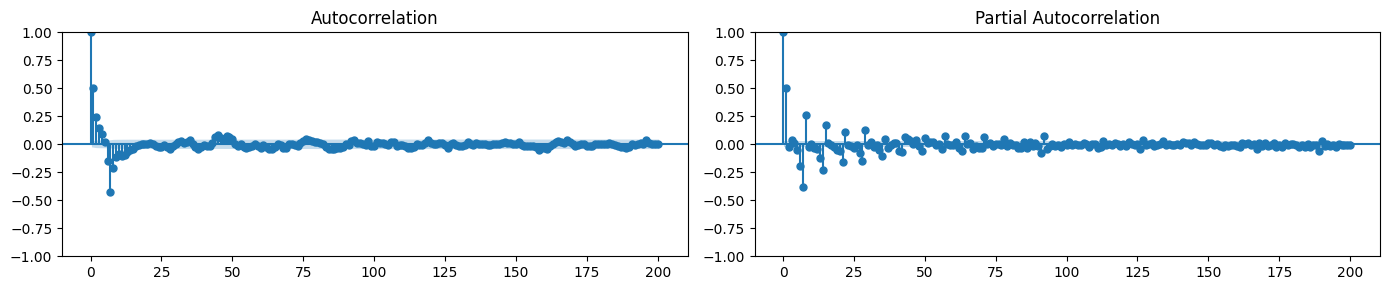

In [32]:
# Plot ACF and PACF of seasonally differenced residuals
fig, ax = plt.subplots(1, 2, figsize=(14, 3))
plot_acf(time_series['week_diff'].dropna(), ax=ax[0], lags=200)
plot_pacf(time_series['week_diff'].dropna(), ax=ax[1], lags=200)
plt.tight_layout()
plt.show()

**MA(Q) = 1 or 2**:  The ACF chart appears to rebound to zero by the second week.  
**AR(P) = 4 or 5**:  The PACF chart appears to rebound to zero by the fourth or fifth week.  
The first SARIMA model should try (1,1,1) (4,1,1) with 7-day seasonality.

In [33]:
sarima_model = SARIMAX(train_df['Count'], 
                       order=(1, 1, 1), 
                       seasonal_order=(4, 1, 1, 7),
                       enforce_stationarity=False, 
                       enforce_invertibility=False)

sarima_results = sarima_model.fit(maxiter=2000, method='powell', disp=False)
print(sarima_results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Count   No. Observations:                 4163
Model:             SARIMAX(1, 1, 1)x(4, 1, 1, 7)   Log Likelihood              -33321.211
Date:                           Mon, 20 May 2024   AIC                          66658.423
Time:                                   21:36:48   BIC                          66709.023
Sample:                               01-01-2010   HQIC                         66676.331
                                    - 05-25-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5903      0.008     77.239      0.000       0.575       0.605
ma.L1         -1.0000      0.152     -6.581

In [34]:
# Forecast using the SARIMA model
sarima_pred = sarima_results.get_forecast(steps=len(test_df))
sarima_y_pred = sarima_pred.predicted_mean

# Calculate evaluation metrics
sarima_mae = mean_absolute_error(test_df['Count'], sarima_y_pred)
sarima_mape = mean_absolute_percentage_error(test_df['Count'], sarima_y_pred)
sarima_mse = mean_squared_error(test_df['Count'], sarima_y_pred)
sarima_rmse = root_mean_squared_error(test_df['Count'], sarima_y_pred)

# Print evaluation metrics
print('SARIMA model errors')
print('-------------------------')
print(f'MAE: {sarima_mae}')
print(f'MAPE: {sarima_mape:.4f}')
print(f'MSE: {sarima_mse}')
print(f'RMSE: {sarima_rmse}')

SARIMA model errors
-------------------------
MAE: 1181.8241227625024
MAPE: 0.1470
MSE: 2317132.588501872
RMSE: 1522.2130562118668


In [35]:
# # Try auto_arima
# auto_model = pm.auto_arima(time_series['Count'], seasonal=True, m=7, trace=True,
#                            start_p=2, d=1, start_q=1,
#                            max_p=5, max_q=3,
#                            start_P=4, D=1, start_Q=1,
#                            max_P=6, max_Q=3,
#                            error_action='ignore', suppress_warnings=True,
#                            stepwise=True, method='powell')

# print(auto_model.summary())

**Auto-ARIMA**  
This model is computationally intensive.  It suggests SARIMA (2,1,1) (4,1,1,7) with trend='c'

In [36]:
sarima_model2 = SARIMAX(train_df['Count'], 
                        order=(2, 1, 1), 
                        seasonal_order=(4, 1, 1, 7),
                        enforce_stationarity=False, 
                        enforce_invertibility=False)

sarima_results2 = sarima_model2.fit(maxiter=2000, method='powell', disp=False)
print(sarima_results2.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Count   No. Observations:                 4163
Model:             SARIMAX(2, 1, 1)x(4, 1, 1, 7)   Log Likelihood              -33292.036
Date:                           Mon, 20 May 2024   AIC                          66602.072
Time:                                   21:37:28   BIC                          66658.996
Sample:                               01-01-2010   HQIC                         66622.219
                                    - 05-25-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5915      0.010     60.093      0.000       0.572       0.611
ar.L2          0.0068      0.012      0.589

In [37]:
# Forecast using the SARIMA model
sarima_pred2 = sarima_results2.get_forecast(steps=len(test_df))
sarima_y_pred2 = sarima_pred2.predicted_mean

# Calculate evaluation metrics
sarima_mae2 = mean_absolute_error(test_df['Count'], sarima_y_pred2)
sarima_mape2 = mean_absolute_percentage_error(test_df['Count'], sarima_y_pred2)
sarima_mse2 = mean_squared_error(test_df['Count'], sarima_y_pred2)
sarima_rmse2 = root_mean_squared_error(test_df['Count'], sarima_y_pred2)

# Print evaluation metrics
print('SARIMA model errors')
print('-------------------------')
print(f'MAE: {sarima_mae2}')
print(f'MAPE: {sarima_mape2:.4f}')
print(f'MSE: {sarima_mse2}')
print(f'RMSE: {sarima_rmse2}')

SARIMA model errors
-------------------------
MAE: 1131.767244463101
MAPE: 0.1402
MSE: 2154120.928068788
RMSE: 1467.6923819618291


This is the best iteration of SARIMA with 7-day seasonality, but it performs worse than the simpler ARIMA model.
To address this, consider exogenous variables in the SARIMAX model.

&nbsp;

### SARIMAX  
- Test exogenous variables for COVID Lockdowns, weekends, winter and weather

In [38]:
# Define exogenous variables
time_series.columns

Index(['Count', 'covid', 'winter', 'weekend', '311_app', 'temperature_2m_max',
       'temperature_2m_min', 'temperature_2m_mean', 'daylight_duration',
       'rain_sum', 'snowfall_sum', 'wind_speed_10m_max', 'population',
       'Count_diff', 'week_diff'],
      dtype='object')

In [39]:
exog_cols = ['weekend', 'temperature_2m_max', 'temperature_2m_min', 'daylight_duration', 'temperature_2m_mean', 'rain_sum', 'snowfall_sum', '311_app']

# Fit the SARIMA model with the Auto ARIMA parameters and the COVID dummy variable
sarimax_model = SARIMAX(train_df['Count'], 
                        exog=train_df[exog_cols],
                        order=(1, 1, 1), 
                        #seasonal_order=(4, 1, 1, 7),
                        enforce_stationarity=False, 
                        enforce_invertibility=False)

sarimax_results = sarimax_model.fit(disp=False, method='powell', maxiter=1000)

In [40]:
# Forecast using the SARIMA model
sarimax_pred = sarimax_results.get_forecast(steps=len(test_df), exog=test_df[exog_cols])
sarimax_y_pred = sarimax_pred.predicted_mean

# Calculate evaluation metrics
sarimax_mae = mean_absolute_error(test_df['Count'], sarimax_y_pred)
sarimax_mape = mean_absolute_percentage_error(test_df['Count'], sarimax_y_pred)
sarimax_mse = mean_squared_error(test_df['Count'], sarimax_y_pred)
sarimax_rmse = root_mean_squared_error(test_df['Count'], sarimax_y_pred)

# Print evaluation metrics
print('SARIMAX model errors with exogenous variable')
print('-------------------------')
print(f'MAE: {sarimax_mae}')
print(f'MAPE: {sarimax_mape:.4f}')
print(f'MSE: {sarimax_mse}')
print(f'RMSE: {sarimax_rmse}')

SARIMAX model errors with exogenous variable
-------------------------
MAE: 865.2123715347707
MAPE: 0.0993
MSE: 1385693.5719716887
RMSE: 1177.1548632069141


***Exogenous Results***  
- Tested with and without seasonality.  Across the board, seasonality (i.e. SARIMA) worsens model performance.
- Eliminating seasonality (i.e. ARIMA), but including regressors that stand in for some types of seasonality, improves performance by 9.2% (1.01% absolute).
- Four regressors did not help the outcome: Wind, COVID lockdowns, population and winter
- Results in cell below

(2,1,1)(4,1,1,7), winter = .1436  
(2,1,1)(4,1,1,7), covid = .4282  
(2,1,1)(2,1,1,7), covid = .4593  
(2,1,1)(4,1,1,7), weekend =.1380  
(1,1,1)(4,1,1,7), weekend =.1430  
(2,1,1)(4,1,1,7), temp_max =.1388  
(2,1,1)(4,1,1,7), temp_min =.1354  
(2,1,1)(4,1,1,7), temp_avg =.1383  
(2,1,1)(4,1,1,7), daylight =.1322  
(2,1,1)(4,1,1,7), rain =.1360  
(2,1,1)(4,1,1,7), snow =.1365  
(2,1,1)(4,1,1,7), wind =.1403  
(2,1,1)(4,1,1,7), app =.1420  
(2,1,1)(4,1,1,7), pop =.2989  
(2,1,1)(4,1,1,7), rain, snow =.1348  

(1,1,1), None = 0.1096  
(1,1,1), weekend = 0.1080  
(1,1,1), winter = 0.1114  
(1,1,1), covid = 0.1268  
(1,1,1), temp_max = 0.1095  
(1,1,1), temp_min = 0.1073  
(1,1,1), temp_avg = 0.1083  
(1,1,1), wind = 0.1109  
(1,1,1), rain = 0.1086  
(1,1,1), snow = 0.1091  
(1,1,1), daylight = 0.1078  
(1,1,1), app = 0.1096  
(1,1,1), pop = 0.1808  

(1,1,1), weekend, temp_max = 0.1072  
(1,1,1), weekend, temp_max, temp_min = 0.1041  
(1,1,1), weekend, temp_max, temp_min, temp_avg = 0.1040  
(1,1,1), weekend, temp_max, temp_min, temp_avg, daylight, rain = 0.1001  
(1,1,1), weekend, temp_max, temp_min, temp_avg, daylight, rain, snow = 0.0995  
(1,1,1), weekend, temp_max, temp_min, temp_avg, daylight, rain, snow, app = 0.0993  

In [41]:
print(sarimax_results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:                 4163
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -33739.465
Date:                Mon, 20 May 2024   AIC                          67500.930
Time:                        21:37:31   BIC                          67570.596
Sample:                    01-01-2010   HQIC                         67525.576
                         - 05-25-2021                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
weekend             -1550.1324     26.148    -59.284      0.000   -1601.381   -1498.884
temperature_2m_max     83.4349     50.161      1.663      0.096     -14.879     181.749
temperature_2m_m

<br>

### Prophet
- Switch to using Facebook's Prophet model
- Capable of analyzing multiple seasonalities
- Can take in exogenous variables
- Can take into account holidays and one time events, such as COVID lockdowns

In [42]:
time_series.columns

Index(['Count', 'covid', 'winter', 'weekend', '311_app', 'temperature_2m_max',
       'temperature_2m_min', 'temperature_2m_mean', 'daylight_duration',
       'rain_sum', 'snowfall_sum', 'wind_speed_10m_max', 'population',
       'Count_diff', 'week_diff'],
      dtype='object')

In [43]:
# Create and concatenate all holidays into a single variable

# Add US holidays
us_holidays = make_holidays_df(year_list=range(2010, 2025), country='US')

# Create a special COVID lockdown "holiday" category
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days

# NYC-specific events
nyc_marathon = pd.DataFrame({
    'holiday': 'NYC Marathon',
    'ds': pd.to_datetime(['2010-11-07','2011-11-06','2013-11-03','2014-11-02','2015-11-01','2016-11-06',
                          '2017-11-05','2018-11-04','2019-11-03','2021-11-07','2022-11-06','2023-11-05']),
    'lower_window': 0,
    'upper_window': 1,
})

nyc_storms = pd.DataFrame({
    'holiday': 'NYC Storms',
    'ds': pd.to_datetime(['2011-08-27','2011-08-28','2011-08-29','2011-10-29','2011-10-30','2011-10-31',
                          '2016-01-22','2016-01-23','2016-01-24','2016-01-25','2020-08-04','2020-08-05']),
    'lower_window': 0,
    'upper_window': 1,
})

holidays = pd.concat([us_holidays, nyc_marathon, nyc_storms, lockdowns])

In [44]:
prophet_df = time_series.drop(columns=['Count_diff', 'week_diff'], axis=1).reset_index().rename(columns={'index': 'ds', 'Count': 'y'})

# Split the data into training and testing sets (80%/20% split)
split_index = int(len(prophet_df) * 0.8)
train_df = prophet_df.iloc[:split_index]
test_df = prophet_df.iloc[split_index:]

21:47:20 - cmdstanpy - INFO - Chain [1] start processing
21:47:24 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Rick\Flatiron\Capstone\capstone_env\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\Rick\Flatiron\Capstone\capstone_env\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


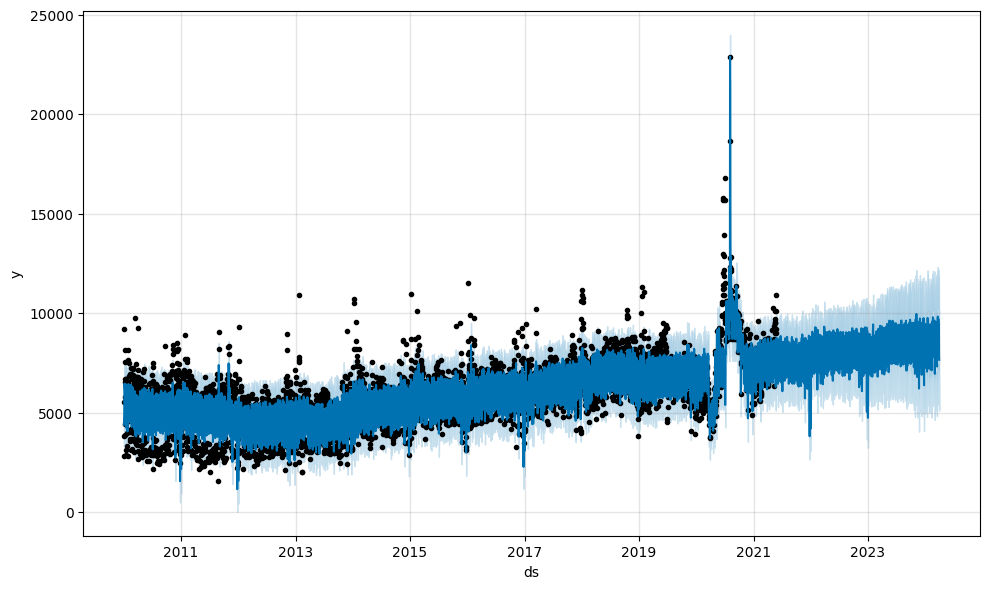

In [50]:
# Instantiate
prophet_model = Prophet(yearly_seasonality=False,
                        weekly_seasonality=False,
                        daily_seasonality=False,
                        holidays=holidays,
                        changepoint_prior_scale=.13)

# Regressor list
regressor_list = [
    # 'covid',
    # 'winter',
     'weekend',
    # 'temperature_2m_max',
     'temperature_2m_min',
     'temperature_2m_mean',
     'daylight_duration',
     'rain_sum',
     '311_app',
    # 'population'
    # 'snowfall_sum',
    # 'wind_speed_10m_max'
]

model_regressors = []
for item in regressor_list:
    model_regressors.append(item)


# Add regressors
for item in model_regressors:
    prophet_model.add_regressor(item)

# Fit
prophet_model.fit(train_df)

# Make future dataframe for predictions and predict
future = prophet_model.make_future_dataframe(periods=len(test_df), freq='D')
future = pd.concat([future, time_series[model_regressors].reset_index(drop=True)], axis=1)
forecast = prophet_model.predict(future)

# Plot the forecast
prophet_model.plot(forecast)
plt.show()

In [51]:
# Extract the predictions for the training and testing periods
train_forecast = forecast.iloc[:split_index]
test_forecast = forecast.iloc[split_index:]

# Calculate evaluation metrics
prophet_y_true = test_df['y'].values
prophet_y_pred = forecast['yhat'].values[-len(test_df):]
prophet_mae = mean_absolute_error(prophet_y_true, prophet_y_pred)
prophet_mape = mean_absolute_percentage_error(prophet_y_true, prophet_y_pred)
prophet_mse = mean_squared_error(prophet_y_true, prophet_y_pred)
prophet_rmse = root_mean_squared_error(prophet_y_true, prophet_y_pred)

print('Prophet model errors')
print('-------------------------')
print(f'MAE: {prophet_mae}')
print(f'MAPE: {prophet_mape:.4f}')
print(f'MSE: {prophet_mse}')
print(f'RMSE: {prophet_rmse}')

Prophet model errors
-------------------------
MAE: 936.0723866373027
MAPE: 0.1028
MSE: 1742212.3145939792
RMSE: 1319.928905128598


***Prophet Performance***
No seasonality, no holidays, no regressors:  0.1154  
D seasonality, no holidays, no regressors:  0.1152  
W seasonality, no holidays, no regressors:  0.2383  
A seasonality, no holidays, no regressors:  0.2863  

No seasonality, COVID holidays, no regressors:  0.1250  
No seasonality, US holidays, no regressors:  0.1120  
No seasonality, NYC storms, no regressors:  0.1153  
No seasonality, NYC marathon, no regressors:  0.1152
No seasonality, US holiday, storms, marathons, no regressors:  0.1118  

No seasonality, three holidays, covid:  0.1422  
No seasonality, three holidays, winter:  0.1126  
No seasonality, three holidays, weekend:  0.1100  
No seasonality, three holidays, temp_max:  0.1129  
No seasonality, three holidays, temp_min:  0.1100  
No seasonality, three holidays, temp_avg:  0.1115  
No seasonality, three holidays, daylight:  0.1113  
No seasonality, three holidays, rain:  0.1113  
No seasonality, three holidays, snow:  0.1120  
No seasonality, three holidays, wind:  0.1130  

No seasonality, three holidays, weekend, temp_min, temp_avg, daylight, rain:  0.1073  
No seasonality, three holidays, COVID lockdown, weekend, temp_min, temp_avg, daylight, rain:  0.1059  
No seasonality, three holidays, COVID lockdown, weekend, temp_min, temp_avg, daylight, rain, chgpt = 0.13:  0.1029  
No seasonality, three holidays, COVID lockdown, weekend, temp_min, temp_avg, daylight, rain, chgpt, app = 0.13:  <'>0.1028</green>  

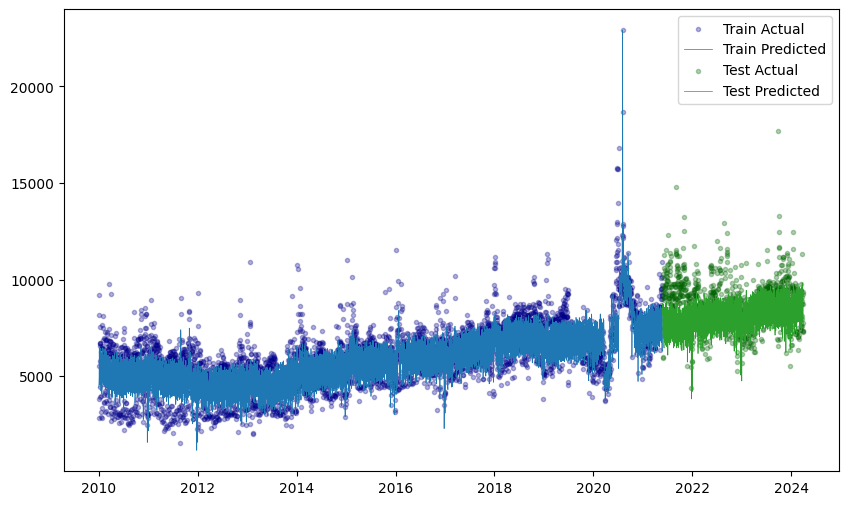

In [66]:
# Plot actual vs. predicted values for the test set
plt.figure(figsize=(10, 6))
plt.scatter(train_df['ds'], train_df['y'], label='Train Actual', marker='.', alpha=.3, color='darkblue')
plt.plot(train_forecast['ds'], train_forecast['yhat'], label='Train Predicted', linestyle='-', linewidth=.5, color='tab:blue')
plt.scatter(test_df['ds'], test_df['y'], label='Test Actual', marker='.', alpha=.3, color='darkgreen')
plt.plot(test_forecast['ds'], test_forecast['yhat'], label='Test Predicted', linestyle='-', linewidth=.5, color='tab:green')
plt.legend()
plt.show()

&nbsp;

### LTSM

In [67]:
time_series.columns

Index(['Count', 'covid', 'winter', 'weekend', '311_app', 'temperature_2m_max',
       'temperature_2m_min', 'temperature_2m_mean', 'daylight_duration',
       'rain_sum', 'snowfall_sum', 'wind_speed_10m_max', 'population',
       'Count_diff', 'week_diff'],
      dtype='object')

In [95]:
features_to_drop = ['Count', 'covid', 'winter', 'wind_speed_10m_max', 'population']

# Assuming 'time_series' is your DataFrame
df = time_series.drop(columns=['Count_diff', 'week_diff'], axis=1).copy()

# Ensure the DataFrame is sorted by date
df = df.sort_index()

# Separate features and target
features = df.drop(columns=features_to_drop)
target = df[['Count']]

# Scale the target using MinMaxScaler
target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = target_scaler.fit_transform(target)

# Combine scaled features and scaled target for sequence creation
scaled_data = np.concatenate((scaled_target, features.values), axis=1)

# Function to create sequences
def create_sequences(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 1:])  # All columns except the target for input
        y.append(data[i + time_steps, 0])  # Target column for output
    return np.array(X), np.array(y)

time_steps = 28  # Number of time steps to look back
X, y = create_sequences(scaled_data, time_steps)

# Reshape X to be [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Split into training and testing data
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build a hybrid CNN-LSTM model
lstm_model = Sequential()
lstm_model.add(Input(shape=(time_steps, X.shape[2])))
lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
lstm_model.add(MaxPooling1D(pool_size=2))
lstm_model.add(Bidirectional(GRU(50, return_sequences=True, kernel_regularizer=l2(0.01))))
lstm_model.add(Dropout(0.4))
lstm_model.add(Bidirectional(GRU(50, return_sequences=False, kernel_regularizer=l2(0.01))))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(25, kernel_regularizer=l2(0.01)))
lstm_model.add(Dense(1))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
lstm_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model
lstm_model.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=100, callbacks=[early_stopping])

# Predict and invert the scaling
train_predictions = lstm_model.predict(X_train)
test_predictions = lstm_model.predict(X_test)

train_predictions = target_scaler.inverse_transform(train_predictions)
test_predictions = target_scaler.inverse_transform(test_predictions)

# Inverse transform y_train and y_test for comparison
train_actual = target_scaler.inverse_transform(y_train.reshape(-1, 1))
test_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 5.0015 - val_loss: 4.0453
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.1953 - val_loss: 3.5345
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.5992 - val_loss: 3.0867
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.1320 - val_loss: 2.7036
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2.7145 - val_loss: 2.3770
Epoch 6/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2.3622 - val_loss: 2.0815
Epoch 7/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2.0678 - val_loss: 1.8348
Epoch 8/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.8141 - val_loss: 1.6223
Epoch 9/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.5979 - val_loss: 1.4386
Epoch 10/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.4149 - val_loss: 1.2775
Epoch 11/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.2568 - val_loss: 1.1419
Epoch 12/100
104/104 ━━━━━━━━

In [96]:
train_lstm_mae = mean_absolute_error(train_actual, train_predictions)
test_lstm_mae = mean_absolute_error(test_actual, test_predictions)
train_lstm_mape = mean_absolute_percentage_error(train_actual, train_predictions)
test_lstm_mape = mean_absolute_percentage_error(test_actual, test_predictions)
train_lstm_mse = mean_squared_error(train_actual, train_predictions)
test_lstm_mse = mean_squared_error(test_actual, test_predictions)
train_lstm_rmse = root_mean_squared_error(train_actual, train_predictions)
test_lstm_rmse = root_mean_squared_error(test_actual, test_predictions)


print('LSTM model errors')
print('-------------------------')
print(f'Train MAE: {train_lstm_mae}')
print(f'Train MAPE: {train_lstm_mape:.4f}')
print(f'Train MSE: {train_lstm_mse}')
print(f'Train RMSE: {train_lstm_rmse}')
print('-------------------------')
print(f'Test MAE: {test_lstm_mae}')
print(f'Test MAPE: {test_lstm_mape:.4f}')
print(f'Test MSE: {test_lstm_mse}')
print(f'Test RMSE: {test_lstm_rmse}')


LSTM model errors
-------------------------
Train MAE: 1275.9350370103034
Train MAPE: 0.2317
Train MSE: 2916489.36163937
Train RMSE: 1707.7732172742874
-------------------------
Test MAE: 3012.6201765730575
Test MAPE: 0.3310
Test MSE: 10575804.13727262
Test RMSE: 3252.046146239721


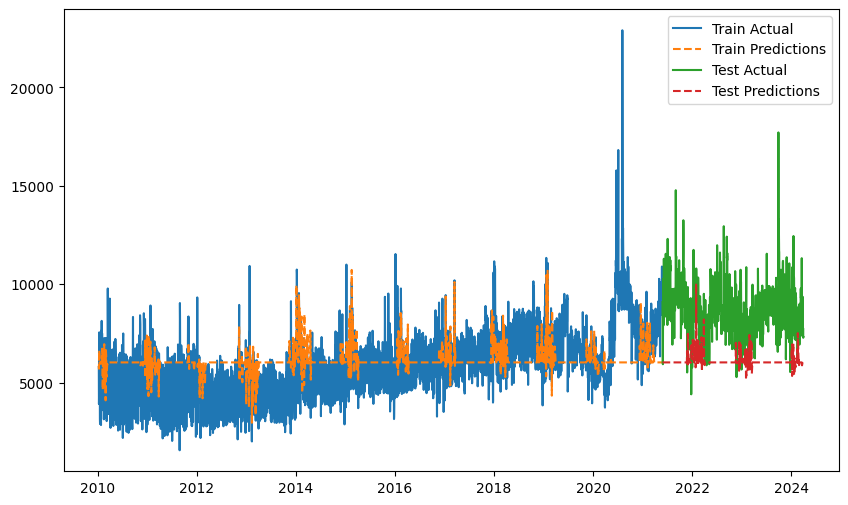

In [75]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df.index[time_steps:split + time_steps], train_actual, label='Train Actual')
plt.plot(df.index[time_steps:split + time_steps], train_predictions, label='Train Predictions', linestyle='--')
plt.plot(df.index[split + time_steps:], test_actual, label='Test Actual')
plt.plot(df.index[split + time_steps:], test_predictions, label='Test Predictions', linestyle='--')
plt.legend()
plt.show()